In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import os
import re

In [2]:
df_clean_data = pd.read_csv('df_final_encoded.csv')
df_clean_data.head()

,year,schizophrenia_disorders,depressive_disorders,anxiety_disorders,bipolar_disorders,eating_disorders,dalys_depressive_disorders,dalys_schizophrenia,dalys_bipolar_disorder,dalys_eating_disorders,dalys_anxiety_disorders,entity_encoded
0,1990,0.223206,4.996118,4.713314,0.703023,0.127700,895.22565,138.24825,147.64412,26.471115,440.33000,0
1,1991,0.222454,4.989290,4.702100,0.702069,0.123256,893.88434,137.76122,147.56696,25.548681,439.47202,0
2,1992,0.221751,4.981346,4.683743,0.700792,0.118844,892.34973,137.08030,147.13086,24.637949,437.60718,0
3,1993,0.220987,4.976958,4.673549,0.700087,0.115089,891.51587,136.48602,146.78812,23.863169,436.69104,0
4,1994,0.220183,4.977782,4.670810,0.699898,0.111815,891.39160,136.18323,146.58481,23.189074,436.76800,0


In [4]:
df_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   year                        6150 non-null   int64  
 1   schizophrenia_disorders     6150 non-null   float64
 2   depressive_disorders        6150 non-null   float64
 3   anxiety_disorders           6150 non-null   float64
 4   bipolar_disorders           6150 non-null   float64
 5   eating_disorders            6150 non-null   float64
 6   dalys_depressive_disorders  6150 non-null   float64
 7   dalys_schizophrenia         6150 non-null   float64
 8   dalys_bipolar_disorder      6150 non-null   float64
 9   dalys_eating_disorders      6150 non-null   float64
 10  dalys_anxiety_disorders     6150 non-null   float64
 11  entity_encoded              6150 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 576.7 KB


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Definir el umbral de la mediana para convertir en variable binaria
threshold = df_clean_data['dalys_eating_disorders'].median()
df_clean_data['target'] = (df_clean_data['dalys_eating_disorders'] >= threshold).astype(int)

# Redefinir características y objetivo
X = df_clean_data.drop(['year', 'anxiety_disorders', 'eating_disorders' ,'dalys_depressive_disorders', 'dalys_bipolar_disorder', 'dalys_anxiety_disorders', 'entity_encoded', 'target'], axis=1)
y = df_clean_data['target'] # Use the 'target' column which is binary

# Escalado de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo de regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predicciones
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluación del modelo
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

conf_matrix, class_report, roc_auc


(array([[611,   2],
        [  2, 615]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       613\n           1       1.00      1.00      1.00       617\n\n    accuracy                           1.00      1230\n   macro avg       1.00      1.00      1.00      1230\nweighted avg       1.00      1.00      1.00      1230\n',
 np.float64(0.9999550527337192))

<Axes: >

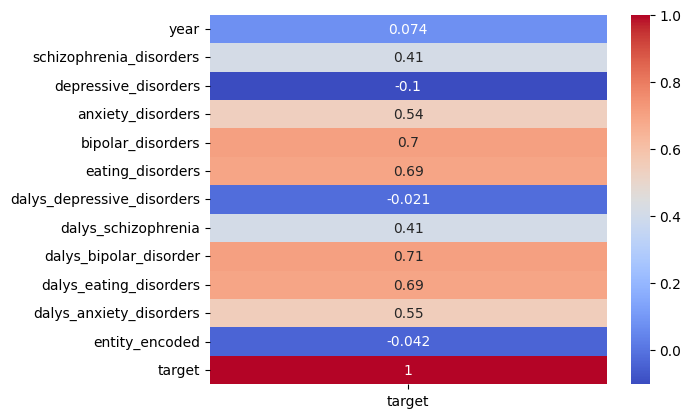

In [6]:
import seaborn as sns
corr_matrix = df_clean_data.corr()
sns.heatmap(corr_matrix[['target']], annot=True, cmap='coolwarm')

In [7]:
# Variables a excluir (por posible leakage o redundancia)
exclude_vars = [
    'year',
    'eating_disorders',          # Posible leakage (misma condición que el target)
    'dalys_depressive_disorders',
    'dalys_schizophrenia',
    'dalys_bipolar_disorder',
    'dalys_anxiety_disorders',
    'entity_encoded',
    'target'
]

# Definir X e y
X = df_clean_data.drop(exclude_vars + ['dalys_eating_disorders'], axis=1)  # Predictores
y = df_clean_data['dalys_eating_disorders']  # Variable objetivo

Correlación con dalys_eating_disorders:
 bipolar_disorders          0.672464
anxiety_disorders          0.584395
schizophrenia_disorders    0.496687
depressive_disorders      -0.051787
dtype: float64


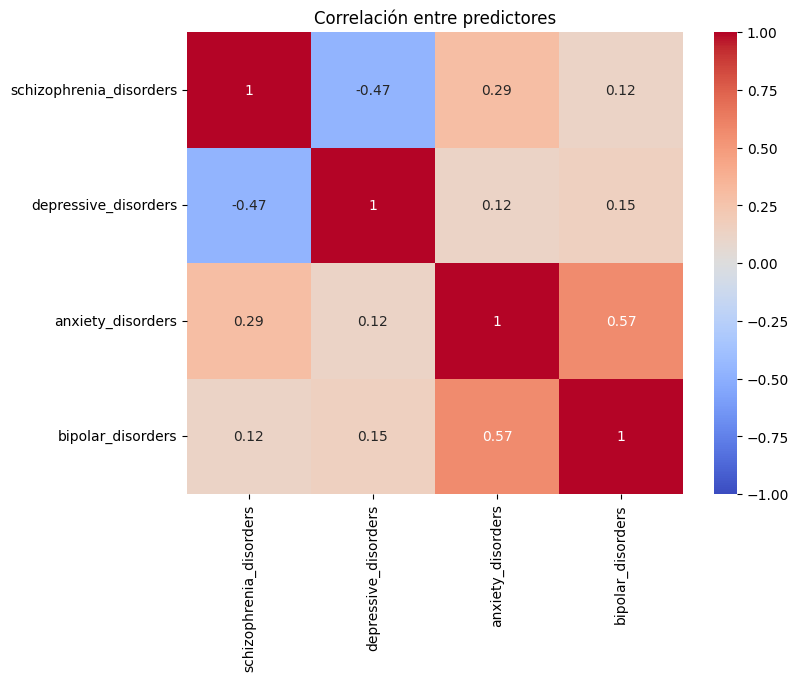

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación de cada variable con el target
corr_with_target = X.corrwith(y).sort_values(ascending=False)
print("Correlación con dalys_eating_disorders:\n", corr_with_target)

# Heatmap de correlación entre predictores
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre predictores")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE from MSE
rmse = np.sqrt(mse)

print(f"R² (Score): {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {rmse:.3f}")



R² (Score): -1.841
RMSE: 51.711


In [10]:
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print(coef_df)

                  Variable  Coeficiente
0  schizophrenia_disorders   307.672814
3        bipolar_disorders    66.817979
2        anxiety_disorders     4.344749
1     depressive_disorders     1.210170


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Crear target binario (1 = alto DALY, 0 = bajo DALY)
threshold = df_clean_data['dalys_eating_disorders'].median()
df_clean_data['target_eating'] = (df_clean_data['dalys_eating_disorders'] >= threshold).astype(int)

# Verificar balanceo de clases
print(df_clean_data['target_eating'].value_counts(normalize=True))

target_eating
0    0.5
1    0.5
Name: proportion, dtype: float64


In [12]:
# Variables a excluir
exclude_vars = [
    'year', 'entity_encoded', 'target',  # No predictivas
    'eating_disorders',                  # Leakage (mismo trastorno que el target)
    'dalys_depressive_disorders',        # Otras métricas DALY
    'dalys_schizophrenia',
    'dalys_bipolar_disorder',
    'dalys_anxiety_disorders',
    'dalys_eating_disorders'             # Target original (no el binario)
]

# Predictores (X) y target (y)
X = df_clean_data.drop(exclude_vars + ['target_eating'], axis=1)
y = df_clean_data['target_eating']

# Mostrar variables seleccionadas
print("Variables predictoras:", X.columns.tolist())

Variables predictoras: ['schizophrenia_disorders', 'depressive_disorders', 'anxiety_disorders', 'bipolar_disorders']


In [13]:
from sklearn.preprocessing import StandardScaler

# Escalar features (importante para regresión logística)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Crear y entrenar modelo
logreg = LogisticRegression(max_iter=1000)  # Aseguramos convergencia
logreg.fit(X_train, y_train)

# Predicciones
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilidades para clase 1

# Matriz de confusión y reporte
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# AUC-ROC
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

Matriz de Confusión:
 [[567  46]
 [ 59 558]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       613
           1       0.92      0.90      0.91       617

    accuracy                           0.91      1230
   macro avg       0.91      0.91      0.91      1230
weighted avg       0.91      0.91      0.91      1230

AUC-ROC: 0.9688436125968679


In [15]:
# Revisar correlación entre variables predictoras y el target
print(X.corrwith(y))

schizophrenia_disorders    0.411097
depressive_disorders      -0.103707
anxiety_disorders          0.538503
bipolar_disorders          0.702657
dtype: float64


In [16]:
# Coefficients
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coef': logreg.coef_[0]
}).sort_values('Coef', key=abs, ascending=False)

print(coef_df)

                  Variable      Coef
3        bipolar_disorders  2.787802
0  schizophrenia_disorders  2.193922
2        anxiety_disorders  0.813226
1     depressive_disorders  0.082346


In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X_scaled, y, cv=5, scoring='roc_auc')
print("AUC en CV:", scores.mean())

AUC en CV: 0.9609147993918963


In [18]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print("AUC Baseline:", roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1]))

AUC Baseline: 0.5


In [19]:
import pandas as pd

# Calcular la prevalencia combinada (suma de porcentajes)
df_clean_data['combined_prevalence'] = df_clean_data[['schizophrenia_disorders',
                                'depressive_disorders',
                                'anxiety_disorders',
                                'bipolar_disorders',
                                'eating_disorders']].sum(axis=1)

# Crear target binario (1 si supera el 60%, 0 si no)
threshold = 0.60  # Umbral del 60%
df_clean_data['high_prevalence_country'] = (df_clean_data['combined_prevalence'] >= threshold).astype(int)

# Ver distribución
print(df_clean_data['high_prevalence_country'].value_counts(normalize=True))

high_prevalence_country
1    1.0
Name: proportion, dtype: float64


In [20]:
# Agrupar por país (entity_encoded) y calcular promedios
country_data = df_clean_data.groupby('entity_encoded').agg({
    'schizophrenia_disorders': 'mean',
    'depressive_disorders': 'mean',
    'anxiety_disorders': 'mean',
    'bipolar_disorders': 'mean',
    'eating_disorders': 'mean',
    'high_prevalence_country': 'first'  # Target (asumimos que es constante por país)
}).reset_index()

# Definir X e y
X = country_data.drop(['entity_encoded', 'high_prevalence_country'], axis=1)
y = country_data['high_prevalence_country']

# Escalar datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [21]:
import numpy as np

print("Distribución de clases en y:", np.unique(y, return_counts=True))

# Ejemplo: Usar la mediana en lugar de un percentil fijo
threshold = df_clean_data['combined_prevalence'].median()
df_clean_data['high_prevalence_country'] = (df_clean_data['combined_prevalence'] >= threshold).astype(int)

from sklearn.utils import resample

# Balancear las clases (oversampling de la clase minoritaria)
class_0 = df_clean_data[df_clean_data['high_prevalence_country'] == 0]
class_1 = df_clean_data[df_clean_data['high_prevalence_country'] == 1]

class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0))
df_balanced = pd.concat([class_0, class_1_oversampled])

# Redefinir X e y con el dataset balanceado
X = df_balanced.drop(['high_prevalence_country', 'entity_encoded'], axis=1)
y = df_balanced['high_prevalence_country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Clases en y_train:", np.unique(y_train))

if len(np.unique(y_train)) >= 2:
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
else:
    print("Error: y_train no contiene suficientes clases.")





Distribución de clases en y: (array([1]), array([205]))
Clases en y_train: [0 1]


In [22]:
# 1. Agrupar datos originales por país (promedio de variables)
# Use 'first' or 'last' to get the original binary value
country_data = df_clean_data.groupby('entity_encoded').agg({
    'schizophrenia_disorders': 'mean',
    'depressive_disorders': 'mean',
    'anxiety_disorders': 'mean',
    'bipolar_disorders': 'mean',
    'eating_disorders': 'mean',
    'high_prevalence_country': 'first'  # Preserve original target value
}).reset_index()

# 2. Definir X e y a nivel país
X_country = country_data[['schizophrenia_disorders', 'depressive_disorders', 'anxiety_disorders', 'bipolar_disorders', 'eating_disorders']]
y_country = country_data['high_prevalence_country']  # Now a binary target

# 3. Entrenar modelo y predecir
model.fit(X_country, y_country)
y_proba_country = model.predict_proba(X_country)[:, 1]

# 4. Crear resultados
results = pd.DataFrame({
    'country_code': country_data['entity_encoded'],
    'probability_high_prevalence': y_proba_country
})